In [2]:
# import libs
import pandas as pd
import matplotlib.pyplot as mp
import os
import numpy
from datetime import datetime
import time
from dateutil import parser

In [3]:
# Read in files
sample_size = 200
files = os.listdir('/Users/Lucas/Downloads/Data/Stocks/')
master_df = pd.DataFrame()
for file in files[0:sample_size]:
    if(file.endswith('.csv')):
        try:
            df = pd.read_csv('/Users/Lucas/Downloads/Data/Stocks/'+file)
            df['Symbol'] = [file]*len(df)
            master_df = pd.concat([master_df, df], axis=0)
        except:           
            continue

df = master_df
df = df.drop(['OpenInt'], axis=1)

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Symbol
0,2005-02-25,13.660,14.043,13.553,13.991,307538,ava.us.csv
1,2005-02-28,13.835,13.998,13.605,13.998,311838,ava.us.csv
2,2005-03-01,13.966,14.043,13.782,13.882,235085,ava.us.csv
3,2005-03-02,13.737,13.966,13.660,13.805,151032,ava.us.csv
4,2005-03-03,13.813,13.899,13.637,13.774,217362,ava.us.csv


In [5]:
# Sort values by date
df = df.sort_values('Date')

In [6]:
# Use date column to create timestamps
timestamps = []
count = 0

for i, row in df.iterrows():
    date = parser.parse(row['Date'])
    temp = time.mktime(date.timetuple())
    timestamps.append(temp)
    count = count + 1
        
# Assign to newly created timestamp values to 'Timestamp' column
df['Timestamp'] = timestamps

Timestamp 1.000094e+09 corresponds to the date 2001-09-10


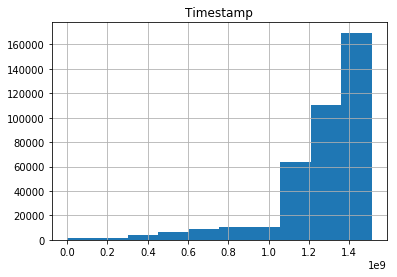

In [7]:
# Lets get an idea of how our stock data is distributed across time
# Data is clearly most concentrated after timestamp 1.0e9, which corresponds to 2001 and onwards
#
# TODO: Index plot by date to increase readability

date = df.loc[df['Timestamp'] > 1e9]
print('Timestamp %e corresponds to the date %s' % (date['Timestamp'].iloc[1], date['Date'].iloc[1]))

_ = df.hist('Timestamp')

In [8]:
# It might be useful to consider market volatility, in addition to the trading volume already provided
# The 'Daily Change' is intended to be an indication of market volatility
# It is calculated by taking the difference between the high and low price for a given trading day

delta = []
for i, row in df.iterrows():
    _open = row['Open'] 
    close = row['Close']
    delta.append(close-_open)
    

df['Daily Change'] = delta

In [9]:
# Track which days (for each stock) displayed a positive change,
# meaning the SP (Stock Price) increased from open to close. 

positive = []
for i, row in df.iterrows():
    change = row['Daily Change']
    if(change > 0):            #positive
        positive.append('1')
    elif(change < 0):          #negative
        positive.append('-1')
    else:                      #neutral
        positive.append('0')
        
df['Positive'] = positive

It would be more meaningful to track the varience of a stock's price 
as a percentage the price for that stock, rather than an absolute change. 

Consider a dollar change in SP for GOOG (SP on the order of > 100\$ per share) versus a dollar change for a penny stock valued at < 1$ per share. These are clearly not equivalently impactful changes, hence the need for this column

In [10]:
delta = []
for i, row in df.iterrows():
    change = row['Daily Change']
    close = row['Open']
    delta.append((change/close)*100)
    
df['Daily Change Percentage'] = delta

In [11]:
# Add a color column to track colour, as seen below
df['color'] = 'g'
df.loc[df['Positive'] == '-1', 'color'] = 'r'

In [12]:
df.head()

,Date,Open,High,Low,Close,Volume,Symbol,Timestamp,Daily Change,Positive,Daily Change Percentage,color
0,1970-01-02,167.25,173.91,167.25,173.91,9300,nav.us.csv,104400.0,6.66,1,3.982063,g
1,1970-01-05,174.74,184.72,174.74,182.23,17700,nav.us.csv,363600.0,7.49,1,4.286368,g
2,1970-01-06,182.23,184.72,179.73,183.06,12300,nav.us.csv,450000.0,0.83,1,0.455468,g
3,1970-01-07,183.06,183.89,180.56,180.56,7900,nav.us.csv,536400.0,-2.50,-1,-1.365672,r
4,1970-01-08,180.56,182.23,179.73,180.56,7800,nav.us.csv,622800.0,0.00,0,0.000000,g


## Plot the percent change for each stock over time

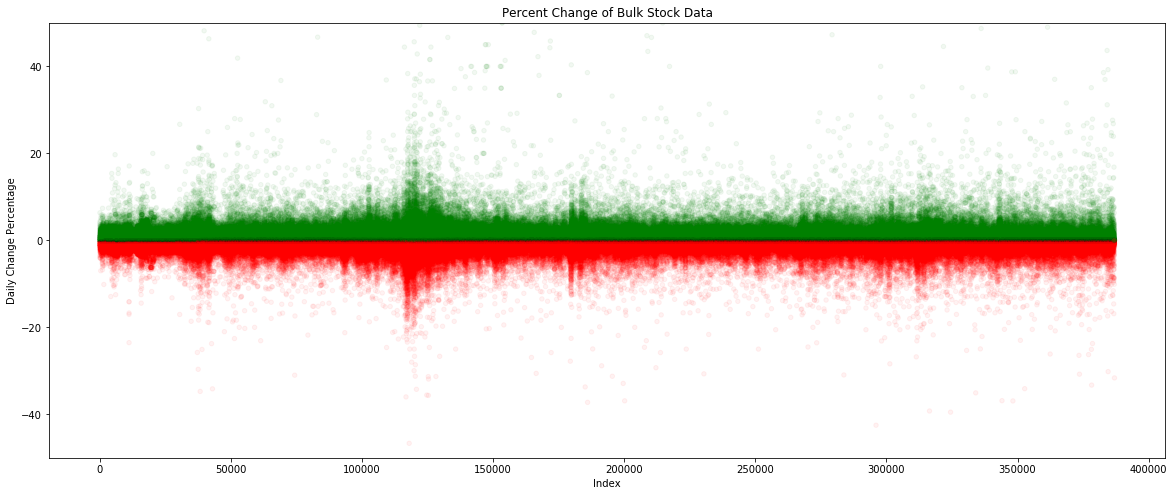

In [13]:
# TODO: Index plot by date to increase readability

df['Time'] = pd.to_datetime(df['Date'])
df['Index'] = list(range(0,len(df)))
df.plot(color=df['color'],
            kind='scatter',
            x='Index',
            y='Daily Change Percentage',
            alpha=0.05, 
            figsize=(20,8),
            title='Percent Change of Bulk Stock Data')
_ = mp.ylim(-50,50)

It is interesting to see that the data is almost perfectly reflected about the x axis,
indicating that periods of positive change are matched with negative changes

The period of volatility around index 100000 corresponds roughly to the 2008-2009 market crash

----------------------------------------------------------------------------------------------------------------------




# Random Forest Classifier

Problem Statement: Given today's open, high, low and volume, what will the closing price be?

__Features:__
- Open
- High
- Low
- Volume
- Stock Symbol


__Label__:
-  Close

In [144]:
# Import sci-kit Random Forest Classifier and other relevant libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import tree

In [145]:
# Plot formatting
figsize = mp.rcParams["figure.figsize"]
figsize[0] = 16
figsize[1] = 5

In [146]:
# Initialize Dataframe
training_data=df
df.describe()

,Open,High,Low,Close,Volume,Timestamp,Daily Change,Daily Change Percentage,Index,open_bin,close_bin,high_bin,low_bin,vol_bin,stock index,Buy
count,386968.000000,386968.000000,386968.000000,386968.000000,3.869680e+05,3.869680e+05,386968.000000,386968.000000,386968.000000,386968.000000,386968.000000,386968.000000,386968.000000,386968.000000,386968.00000,386968.000000
mean,37.269837,37.752836,36.770659,37.272442,1.512746e+06,1.268622e+09,0.002604,0.045415,193483.500000,14.535621,14.531517,14.600163,14.473220,2.026865,104.37493,1.235916
std,70.087205,70.958961,69.193916,70.086944,4.730975e+06,2.411859e+08,1.107932,3.088925,111708.183821,12.947725,12.944642,13.002090,12.895639,1.377926,58.29624,1.157576
min,0.120100,0.120100,0.112100,0.120100,0.000000e+00,1.044000e+05,-55.647000,-90.138136,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.00000,-1.000000
25%,9.361475,9.500000,9.220000,9.369100,3.360375e+04,1.191816e+09,-0.145000,-0.854106,96741.750000,4.000000,4.000000,4.000000,4.000000,1.000000,54.00000,0.000000
50%,19.723000,20.000000,19.417000,19.723000,2.129330e+05,1.330060e+09,0.000000,0.000000,193483.500000,12.000000,12.000000,12.000000,12.000000,2.000000,108.00000,2.000000
75%,35.176250,35.620000,34.713150,35.165250,1.191272e+06,1.433822e+09,0.150000,0.871460,290225.250000,24.000000,24.000000,24.000000,23.000000,4.000000,161.00000,2.000000
max,1068.750000,1106.240000,1047.050000,1068.750000,4.098206e+08,1.510290e+09,38.400000,902.456732,386967.000000,49.000000,49.000000,49.000000,49.000000,4.000000,198.00000,2.000000


## Bin Price Columns

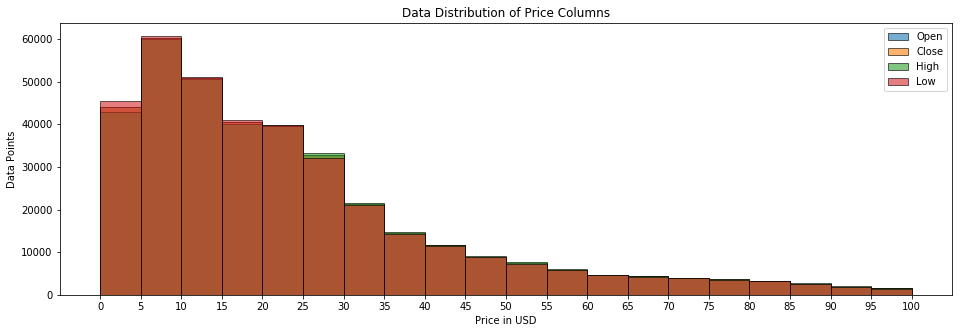

In [147]:
# Plot the distribution of the data in the price columns of interest
col_names = ['Open', 'Close', 'High', 'Low' ]

a = .6
lw = 1
upper_plot_lim = 101

for _col in col_names:
    mp.hist(training_data[_col], alpha=a, label=_col, bins = list(range(0,upper_plot_lim, 5)), edgecolor='black', linewidth=lw)

mp.xticks(range(0,upper_plot_lim,5))
mp.legend(loc='upper right')
mp.title('Data Distribution of Price Columns')
mp.xlabel('Price in USD')
mp.ylabel('Data Points')
mp.show()

In [148]:
# Binning parameters for price bins. Price bins include Open, Close, High and Low.
price_bin_range = 1
price_bin_count = 50
bins = list(range(0, price_bin_count, price_bin_range))

In [149]:
# Bin data

open_bin = []
high_bin = []
close_bin = []
low_bin = []

for i, row in training_data.iterrows():
    o = row['Open']
    hi = row['High']
    cl = row['Close']
    lo = row['Low']
    
    group = [o,hi,cl,lo]
    bin_group = [open_bin, high_bin, close_bin, low_bin]
    
    for k, item in enumerate(group):
        for j, _bin in enumerate(bins):
            if (item < _bin + price_bin_range):
                item = j
                bin_group[k].append(item)
                break
            # Discard this data as it corresponds to an outlier
            elif(item >= price_bin_count):
                item = -1
                bin_group[k].append(item)
                break

In [150]:
# Add newly created bins to the dataframe
training_data['open_bin'] = open_bin
training_data['close_bin'] = close_bin
training_data['high_bin'] = high_bin
training_data['low_bin'] = low_bin

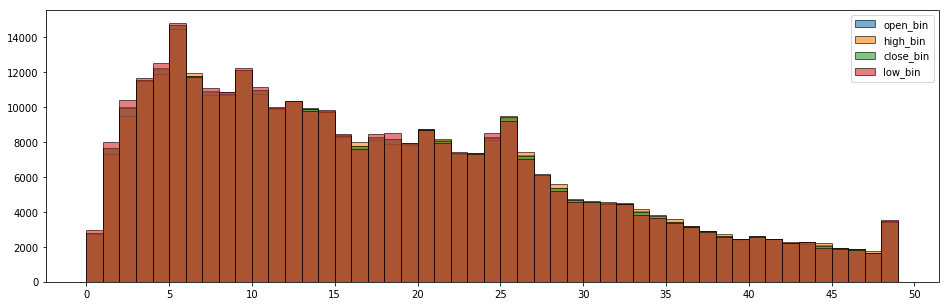

In [151]:
a = .6
lw = 1
upper_limit = 51

bin_names = ['open_bin', 'high_bin', 'close_bin', 'low_bin' ]

for _bin in bin_names:
    mp.hist(training_data[_bin], alpha=a, label=_bin, bins = list(range(0, price_bin_count, price_bin_range)), edgecolor='black', linewidth=lw)

mp.xticks(range(0, upper_limit,5))
mp.legend(loc='upper right')
mp.show()

## Bin Volume Column

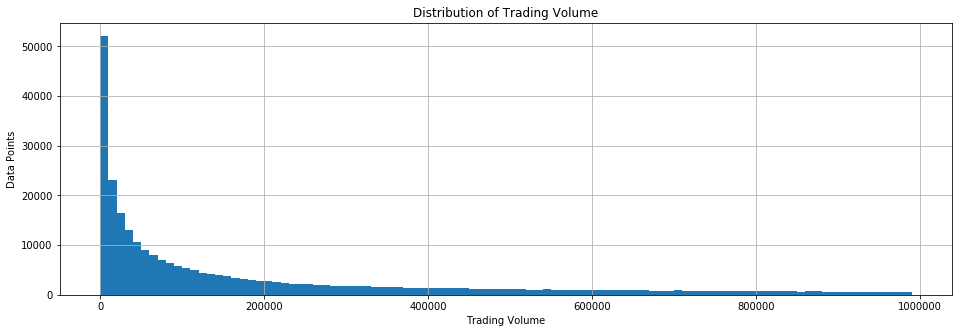

In [152]:
# Plot distribution of volume

training_data.hist('Volume', bins = list(range(0,1000000 ,10000)))
mp.title('Distribution of Trading Volume')
mp.xlabel('Trading Volume')
mp.ylabel('Data Points')
mp.show()

In [153]:
# Volume bin 
volume_bin_count = 4
vol_bin = list(range(0,volume_bin_count))

In [154]:
# Bin volume on a logarithmic scale to obtain a more balanced distribution across bins
# [0-10000][10000-100000][100000-1000000][1000000-infinity]

lower_lim = 10000
lower_exponent = numpy.log10(lower_lim)
upper_lim = 1000000
upper_exponent = numpy.log10(upper_lim)
vol_bin = []

for i, row in training_data.iterrows():
    vol = row['Volume']
    
    # If above the upper limit, assign to highest bin
    if(vol >= pow(10,upper_exponent)):
        vol_bin.append(volume_bin_count)
        continue
    
    # Otherwise, assign to corresponding bin
    for j, _bin in enumerate(bins):
        if(vol < pow(10,lower_exponent+j)):
            vol_bin.append(j)
            break
            

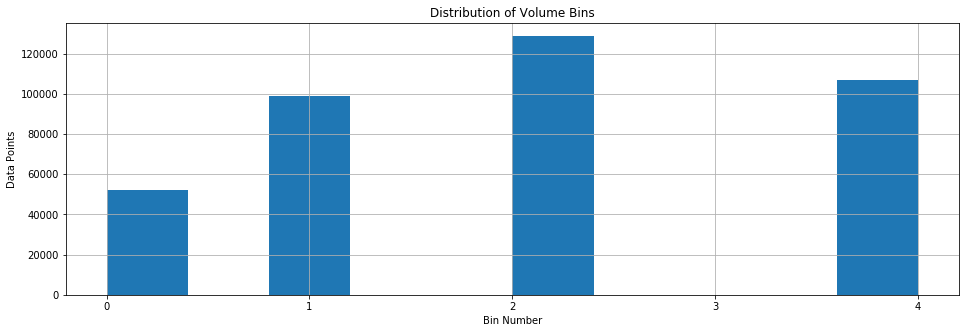

In [157]:
# Plot the bin distribition

training_data['vol_bin'] = vol_bin
_ = training_data.hist("vol_bin")   # empty variable used to suppress useless output
_ = mp.title('Distribution of Volume Bins')
_ = mp.xticks(range(0,5,1))
_ = mp.xlabel('Bin Number')
_ = mp.ylabel('Data Points')

In [158]:
# Convert Symbol to an index and bin each stock index accordingly

stock_names = set(training_data['Symbol'])
stock_index = []

for i, row in training_data.iterrows():
    stockname = row['Symbol']
    for index, name in enumerate(list(stock_names)):
        if (stockname == name):
            stock_index.append(index)
            

In [159]:
training_data['stock index'] = stock_index
training_data.head()

,Date,Open,High,Low,Close,Volume,Symbol,Timestamp,Daily Change,Positive,...,color,Time,Index,open_bin,close_bin,high_bin,low_bin,vol_bin,stock index,Buy
0,1970-01-02,167.25,173.91,167.25,173.91,9300,nav.us.csv,104400.0,6.66,1,...,g,1970-01-02,0,-1,-1,-1,-1,0,169,-1
1,1970-01-05,174.74,184.72,174.74,182.23,17700,nav.us.csv,363600.0,7.49,1,...,g,1970-01-05,1,-1,-1,-1,-1,1,169,-1
2,1970-01-06,182.23,184.72,179.73,183.06,12300,nav.us.csv,450000.0,0.83,1,...,g,1970-01-06,2,-1,-1,-1,-1,1,169,-1
3,1970-01-07,183.06,183.89,180.56,180.56,7900,nav.us.csv,536400.0,-2.50,-1,...,r,1970-01-07,3,-1,-1,-1,-1,0,169,-1
4,1970-01-08,180.56,182.23,179.73,180.56,7800,nav.us.csv,622800.0,0.00,0,...,g,1970-01-08,4,-1,-1,-1,-1,0,169,-1


## Training the Model and Extracting Results

In [160]:
# Filter out data marked as unwanted (bin index of -1)
feats_labels = training_data[['open_bin', 'close_bin', 'high_bin', 'low_bin', 'stock index','vol_bin']]
feats_labels = feats_labels[~feats_labels['open_bin'].isin([-1])]
feats_labels = feats_labels[~feats_labels['close_bin'].isin([-1])]
feats_labels = feats_labels[~feats_labels['high_bin'].isin([-1])]
feats_labels = feats_labels[~feats_labels['low_bin'].isin([-1])]

In [161]:
# Identify features and labels for training 
features = feats_labels[['open_bin', 'vol_bin', 'high_bin', 'low_bin', 'stock index']]
labels = feats_labels[['close_bin']]

# Split test and training data
X_train, X_test, y_train, y_test = train_test_split(
    features, labels,
    test_size=0.33, random_state=75)

# Instantiate, train and test the model
# TODO: Experiment with hyperparameter selection for RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [162]:
# Generate classification report to visualize results
cf_report = classification_report(y_true = y_test, y_pred=y_pred)
print (cf_report)

             precision    recall  f1-score   support

          0       0.98      0.99      0.98       911
          1       0.97      0.97      0.97      2589
          2       0.94      0.93      0.94      3240
          3       0.93      0.92      0.93      3809
          4       0.91      0.92      0.92      4068
          5       0.91      0.92      0.91      4781
          6       0.89      0.89      0.89      3911
          7       0.87      0.87      0.87      3601
          8       0.87      0.86      0.86      3619
          9       0.88      0.87      0.88      4026
         10       0.85      0.86      0.86      3660
         11       0.82      0.82      0.82      3278
         12       0.81      0.84      0.83      3369
         13       0.82      0.83      0.82      3212
         14       0.83      0.81      0.82      3270
         15       0.78      0.78      0.78      2803
         16       0.78      0.76      0.77      2527
         17       0.79      0.80      0.80   

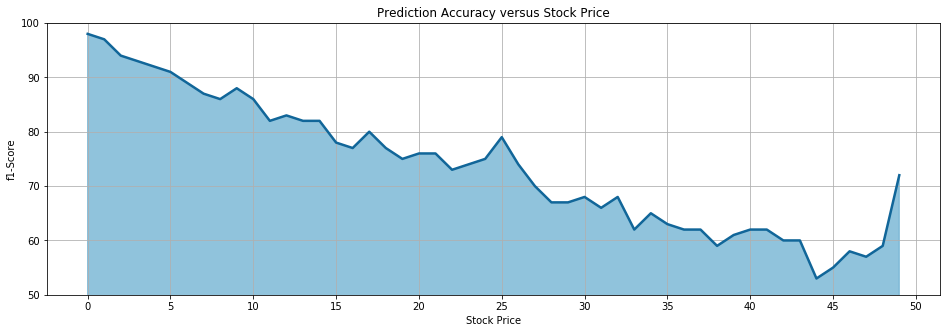

In [163]:
## Plot the classification result as a function of stock price (bin #)

lines = cf_report.split('\n')

indices = []
precision = []
for line in lines[2 : (len(lines) - 3)]:
    t = line.split()
    indices.append(int(t[0]))
    precision.append(float(t[3])*100)

fig, ax = mp.subplots()
ax.fill_between(indices,precision, alpha=.5, color='#2288bb')
ax.set_ylim([50,100])
mp.xticks(range(0, upper_limit+1, 5))
ax.plot(indices,precision,color='#116699', linewidth=2.5)
ax.grid(True)
mp.title("Prediction Accuracy versus Stock Price")
mp.ylabel("f1-Score")
mp.xlabel("Stock Price")
mp.show()


### Discussing results

Prediction accuracy is inversely proportional to the price of the stock. 
This is likely because the percent variance required to change bins is much higher
for stocks that are of lower valued. i.e a stock that is trading at 5.50$ would need to change 
by +/- 20% in order to change bins, whereas a stock that trades at 45.5% would only need to
change +/- 2.5%. In the context of the problem, higher valued stocks are far more volatile and thus
are much harder to predict. 

An interesting characteristic is the spike in prediction accuracy at 25$. This is possibly an product of
market psychology, where 25 is a number where a resistance/support walls would be more likely to form.

Text(0.5,0,'Relative Importance')

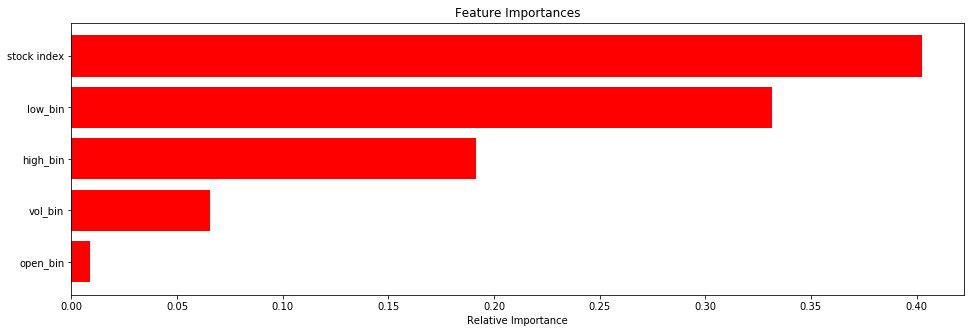

In [164]:
import numpy as np
importances = clf.feature_importances_
indices = np.argsort(importances)

mp.figure(1)
mp.title('Feature Importances')
mp.barh(range(len(indices)), importances[indices], color='r', align='center')
mp.yticks(range(len(indices)), features)
mp.xlabel('Relative Importance')

## Reframe problem: Classify weather a stock will increase, decrease or remain the same

In [165]:
IGNORE = -1
BUY = 0
SELL = 1
HOLD = 2

buy_sell_hold = []

for i, row in training_data.iterrows():
    
    close = row['close_bin']
    open_ = row['open_bin']
    
    if(close == -1 or open_ == -1):
        buy_sell_hold.append(IGNORE)
        continue
        
    change =  close - open_
    
    if(change > 0):
        buy_sell_hold.append(BUY)
    elif(change < 0):
        buy_sell_hold.append(SELL)
    else:
        buy_sell_hold.append(HOLD)
    
#Shift backwards such that nth element will classify n+th prediction 
buy_sell_hold = buy_sell_hold[1:] + [buy_sell_hold[0]]

In [166]:
print(len(training_data))
len(buy_sell_hold)

386968


386968

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a52f6e128>]],
      dtype=object)

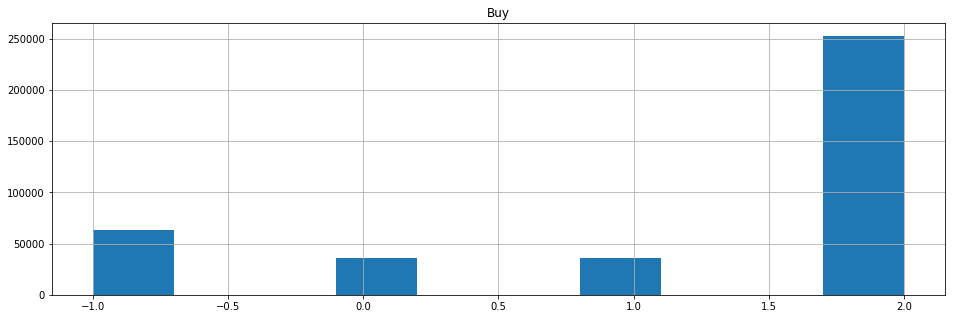

In [167]:
training_data['Buy'] = buy_sell_hold
training_data.hist("Buy")

Most of the "correct" predictions are hold. The resulting prediction will not be particularly useful for trading,
as we are not able to profit by holding a stock.

In [168]:
# Filter out data marked as unwanted (bin index of -1)
# feats_labels = training_data[['open_bin', 'close_bin', 'high_bin', 'low_bin', 'stock index','vol_bin','Buy']]
feats_labels = training_data[['Open', 'Close', 'High', 'Low', 'stock index','Volume','Buy']]
feats_labels = feats_labels[~feats_labels['Buy'].isin([-1])]

In [169]:
# features = feats_labels[['open_bin', 'close_bin', 'high_bin', 'low_bin', 'stock index','vol_bin']]
features = feats_labels[['Open', 'Close', 'High', 'Low', 'stock index','Volume']]


labels = feats_labels[['Buy']]

X_train, X_test, y_train, y_test = train_test_split(
    features, labels,
    test_size=0.33, random_state=75)

clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


In [170]:
cf_report = classification_report(y_true = y_test, y_pred=y_pred)
print (cf_report)

             precision    recall  f1-score   support

          0       0.12      0.03      0.05     11682
          1       0.14      0.04      0.06     11802
          2       0.78      0.94      0.86     83443

avg / total       0.64      0.74      0.68    106927



### Discussing Results
The prediciton accuracy on hold is decent, however the accuracy on buy/sell is very poor.
Because we're only interested in buys and sells this is a not a good solution to the problem.

----------------------------------------------------------------------------------------------------------------------




# Regression approach: LSTM

In [49]:
import sys
sys.path.insert(0, "./anaconda3/lib/python3.6/site-packages")
_ = !pip install tensorflow

In [52]:
_ = training_data.sort_values("Date")

In [53]:
stock_numbers = training_data.groupby("Symbol").agg("count").sort_values("Date", ascending = False)
# stock_train = training_data[training_data["Symbol"] == "nav.us.csv"].sort_values("Date")
stock_train = training_data[training_data["Symbol"] == "nav.us.csv"].sort_values("Volume")
print ("Number of data points to work with:" ,len(stock_train))

Number of data points to work with: 12075


In [106]:
msft_df = pd.read_csv('/Users/Lucas/Downloads/MSFT.csv')

# stock_train[stock_train['Close'] > 70]

# bounded_subset = msft_df[7868:]
bounded_subset = msft_df
bounded_subset.head()
len(bounded_subset)

stock_train = bounded_subset[["Close"]]

In [54]:
msft_df = pd.read_csv('/Users/Lucas/Downloads/MSFT.csv')

stock_train[stock_train['Close'] > 70]
msft_df.iloc[7868]
bounded_subset = msft_df[7868:]
bounded_subset.head()

stock_train = bounded_subset[["Close"]]

In [107]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers

In [108]:
lstm_input = stock_train.values
lstm_input = lstm_input.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(lstm_input)

# Given today's closing price, what is tomorrow's closing price?
- __Feature: Current Price__
- __Label:   Next day's price__

In [109]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[(i + look_back), 0])
    return numpy.array(dataX), numpy.array(dataY)

In [110]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
print(train_size/len(dataset), test_size/len(dataset))
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

0.6699221164544443 0.3300778835455557


In [111]:
train.shape

(5419, 1)

In [112]:
# reshape into X=t and Y=t+1
import numpy
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX[0:5], trainY[0:5].T)

[[7.1824761e-05]
 [1.0773726e-04]
 [1.2570375e-04]
 [9.8759076e-05]
 [8.0802944e-05]] [1.0773726e-04 1.2570375e-04 9.8759076e-05 8.0802944e-05 5.3868629e-05]


In [113]:
# samples need to be in this form: [samples, look_back, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1,testX.shape[1]))
trainY = numpy.reshape(trainY, (trainY.shape[0],1))
testY = numpy.reshape(testY, (testY.shape[0], 1))

In [114]:
print(testX.shape, trainX.shape, trainY.shape, testY.shape)

(2668, 1, 1) (5417, 1, 1) (5417, 1) (2668, 1)


In [115]:
import keras
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = mp.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        mp.plot(self.x, self.losses, label="loss")
        mp.plot(self.x, self.val_losses, label="val_loss")
        mp.legend()
        mp.show();
        
plot_losses = PlotLosses()

In [116]:
# Neural network operations: Wx + b
#backpropagation: go back through the layers and adjust the weights and biases each time
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.pyimagesearch.com/wp-content/uploads/2016/08/simple_neural_network_header.jpg")


## Create and Fit the LSTM model

Hyperparameters of interest are: 
1. Number of hidden layers
2. Learning rate of the optimizer
3. Number of epochs

In [117]:
#hyperparameter configuration
layer_count = 2         #int between 1 and 10
epoch_count = 25        #int from 10-100 
learning_rate = 0.0005  #float, 0.0001 to 0.005

Values were selected using randomized hyperparameter selection. Through trial and error, the above configurations produced the lowest test RMSE.

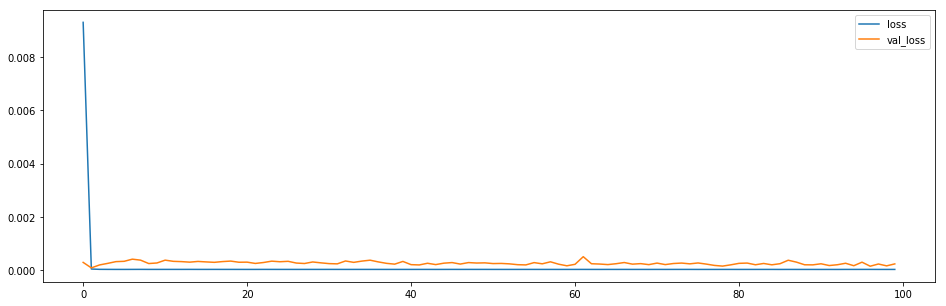

In [118]:
# create and fit the network

model = Sequential()
model.add(LSTM(4, input_shape = (1,1), dropout = 0.0))

for i in range(0, layer_count):
    model.add(Dense(1))

adam = optimizers.adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=adam)
model.fit(trainX, trainY, epochs=epoch_count, batch_size=1, callbacks=[plot_losses], validation_data=(testX, testY), verbose=2)

In [120]:
#get a score
import math

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

Train Score: 0.006 RMSE
Test Score: 0.015 RMSE


In [121]:
# shift train predictions for plotting
look_back = 1
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [134]:
fullPredict = np.concatenate([trainPredict, testPredict],axis = 0)
fullPredict = list(fullPredict)
len(fullPredict)

8085

In [138]:
norm_fullPredict = scaler.fit_transform(fullPredict)
len(norm_fullPredict)
len(dataset)

8089

In [139]:
error = []

for i in list(range(0, (len(norm_fullPredict)))):
    error.append(np.absolute((dataset[i][0]-norm_fullPredict[i][0])*100/dataset[i][0]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


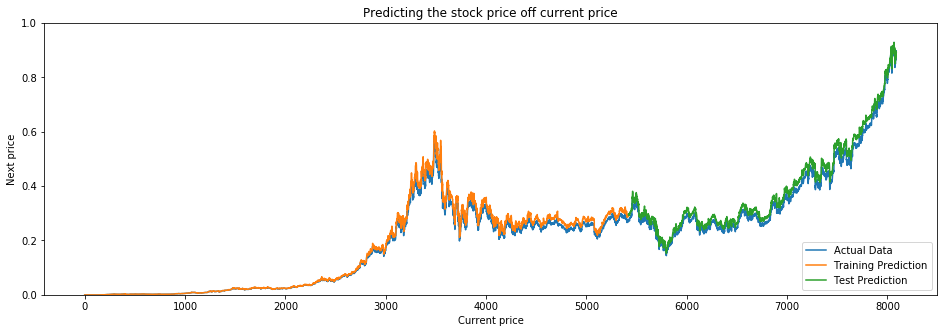

In [125]:
# plot baseline and predictions
mp.plot(scaler.inverse_transform(dataset), label = 'Actual Data')
mp.plot(trainPredictPlot, label = 'Training Prediction')
mp.title("Predicting the stock price off current price")
mp.xlabel("Current price")
mp.ylabel("Next price")
mp.plot(testPredictPlot, label = 'Test Prediction')
mp.legend(loc='lower right')
mp.ylim(0,1)
mp.show()

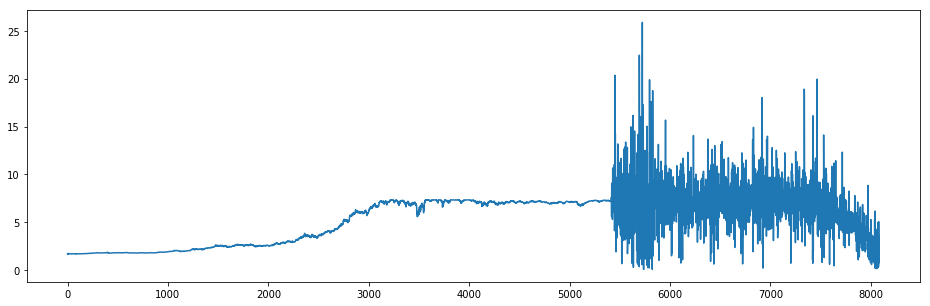

In [140]:
plt = mp.subplot()
plt.plot(error)

In [141]:
miss_count = 0
for i,actual in enumerate(dataset[0:len(error)]):
    miss = error[i]
    actual_error = (miss/actual)*100
    if (actual_error > 20):
        miss_count = miss_count + 1
    
        
print(miss_count/len(error)*100)

99.96289424860854


In [172]:
# Regression vs classification
# (Comparing LSTM vs Random forest classification)
 
# Model Tuning

# number of of features
    # synthetic columns (daily change percentage for example)

# hyperparameter configs
    # number of layers
    # dropout
    # learning rate
    # etc.
    
    # find configs with grid search, random search etc. (find optimal hyperparameters)
